In [81]:
!git clone https://github.com/ahnobari/MOOCP.git
!pip install -U pymoo svgpath2mpl
!mv ./MOOCP/* ./
!rm -r ./MOOCP

fatal: destination path 'MOOCP' already exists and is not an empty directory.


'mv' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.


<font color="red" size="3"><b>WARNING: </b></font> If you plan to work on this notebook in colab we would like to warn you that if you do not download any files you save or save the changes separately, upon the runtime being killed either by you closing the tab/browser or by timing out due to inactivity you WILL LOSE YOUR FILES AND WORK. It is highly recommeneded that you make a local python environment to work.

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import pymoo

# pymoo sub sections
# from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.variable import Real, Integer, Choice, Binary
from pymoo.core.mixed import MixedVariableMating, MixedVariableGA, MixedVariableSampling, MixedVariableDuplicateElimination
from pymoo.optimize import minimize

# Utiliies for working with linkages (DeCoDE Lab)
from linkage_utils import *

# Other modules
import json
from IPython.display import HTML
import matplotlib.animation as animation
from tqdm.autonotebook import trange
import pickle

#set random seed for repeatability
np.random.seed(5)

## Linkage Synthesis Challenge Problem

This challenge problem is focused on synthesizing planar linkage mechanisms such that a specific output curve is traced using the mechanism. For this project you are tasked with synthesizing linkage mechanisms to trace 20 different output shapes. Further, you are tasked with synthesizing mechanisms such that the total material used for the mechanisms in minimized. 

### Overview
The first portion of this notebook will help you understand the linkage design problem and the way we parameterize each linkage design. It will also discuss deliverables and submission instructions. In the second half of this notebook we provide you with a working implementation that you can use as a baseline. **IMPORTANT:** We also provide a **supplementary notebook** with important implementation details and auxiliary information. We highly encourage students to go through this auxiliary notebook after getting oriented with this one. We also provide numerous helper functions in the linkage_utils. We touch on some of these functions in this notebook and go into more details in the supplementary notebook. 

### Project Files and Description of Functions Provided:

All files as well as helper functions and the supplementary notebook and further information can be found in the Github repository of this challenge problem:

[Github Repo](https://github.com/ahnobari/MOOMP)


### Mechanism Representation

For this project, we represent planar mechanisms using the following components:
<ol>
    <li><b>Adjacency/Connectivity Matrix: </b>A linkage mechanisms structure can be represented using a matrix of connectivity (C), which is similar to the adjacency matrix in graphs. The connectivity matrix for a mechanisms with $N$ nodes is a symmetric $N\times N$ matrix with each row and column representing each node and its connections to other nodes. Take the example below:

<img src="https://i2.wp.com/transportgeography.org/wp-content/uploads/connectivity_matrix.png?resize=850%2C348&ssl=1" alt="Connectivity Matrix">

For Node A we use the first row/column of the matrix and we see that A is connected to B (which is represented by the second row/column). To represent this connection in the connectivity matrix we will set the value of the $(1,2)$ and $(2,1)$ elements of the matrix to be 1. Similarly any time any nodes $i$ and $j$ are connected we set the value of the $(i,j)$ and $(j,i)$ elements to be 1 and 0 if the nodes are not connected.</li>
    <li><b>Node Types: </b>To define the mechanism we must also know which nodes are fixed (or ground nodes). For this purpose we store the list of  ground nodes' numbers.</li>
    <li><b>Motor: </b>To simulate the kinematics of the mechanism we also need to know which linkage is driven (i.e., has the motor attached to it). For this purpose we store the numbers of the two nodes that the driven linkage is connected to.</li>
    <li><b>Initial Positions: </b>Finally, we need to know the initial positions of the nodes that make up the mechanism. For this we store the $x,y$ positions of the nodes in a list. Note that all node positions must be floating point numbers between 0 and 1 (i.e., The initial positions of the mechanism must fit into a box of 1x1).</li>
</ol>

#### Example:
Take the following mechanism (Note that node numbers are started from 0 in our representation):

<img src="https://i.ibb.co/qsPC0gC/2021-09-13-0hl-Kleki.png" alt="Numbered Mechanism" border="0">

For this example mechanism we have the following Connectivity Matrix (<code>C</code>), initial positions matrix (<code>x0</code>), motor linkage (<code>motor</code>), and a list of fixed nodes(<code>fixed_nodes</code>):

In [83]:
# Manualy define the connectivity matrix
C = np.array([[0,0,1,0,0],
              [0,0,0,1,0],
              [1,0,0,1,1],
              [0,1,1,0,1],
              [0,0,1,1,0]])

# List of fixed nodes
fixed_nodes = np.array([0,1])

# Initial positions
x0 = np.array([[0.4,0.5],
               [0.6,0.5],
               [0.4,0.6],
               [0.6,0.7],
               [0.5,0.75]])

# Motor 
motor = np.array([2,0])

**Drawing mechanisms:** To visualize this in python we have provided the <code>draw_mechanism(C,x0,fixed_nodes,motor)</code> function to you in the <code>linkage_utils</code> module.

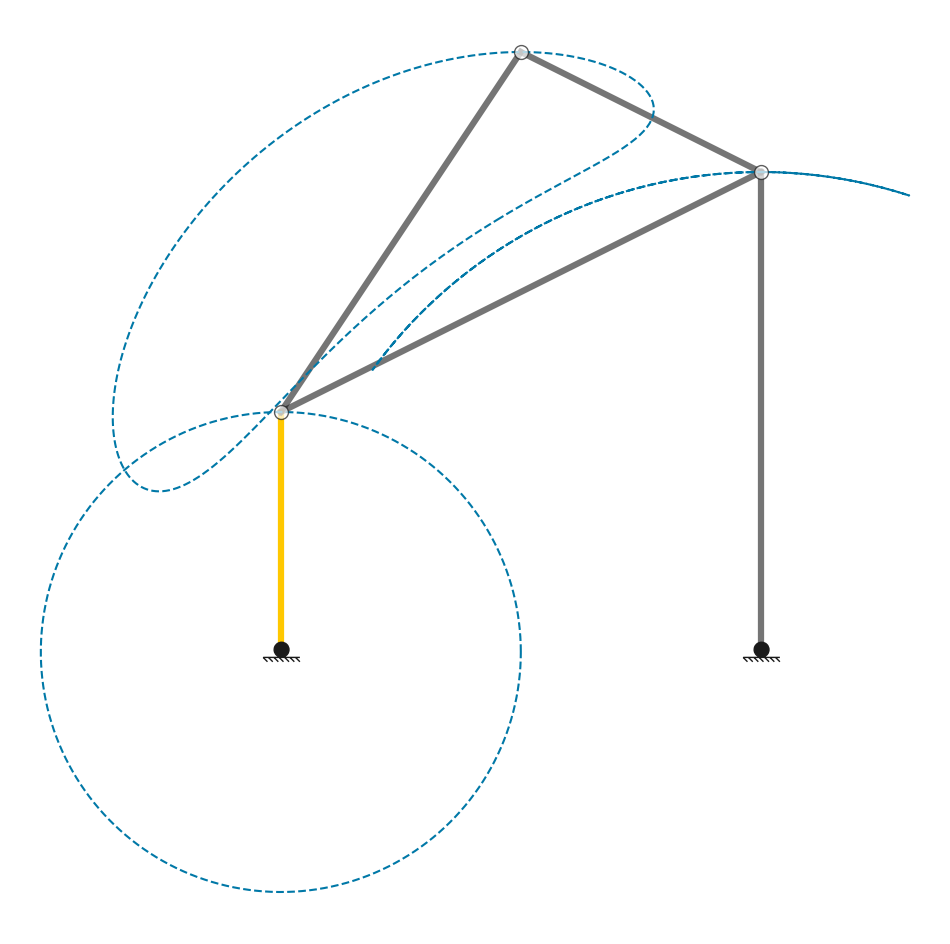

In [84]:
draw_mechanism(C,x0,fixed_nodes,motor)

### Target Curves and Project Objectives

The target curves are provided to you in a specific format. The curves are actually point clouds on a 500x500 grid. These curves are obtained from randomly generated mechanisms so they are all valid curves that 1 DOF planar mechanisms are capable of producing. The curves that are given to you are rasterized and normalized (more details in the supplementary notebook):

You are tasked with generating mechanisms that are capable of producing curves that mimic the target curves as well as possible. We measure the closeness of two point clouds by computing the bi-directional chamfer distance between the two point clouds. 

<img src="https://i.ibb.co/WznB1R8/compare.png" alt="compare" border="0">

The other part of the objective in this challenge problem is reducing the material used by the mechanism. This is the total length of all linkages. We have provided a function that makes this measurement for you using initial positions and adjacency matrix for a mechanism (The functions and useful tools are going to be described later).

[IMPORTANT] In this project three constraints are set for you:
<ul>
    <li><b>Chamfer Distance: </b>Any mechanisms output with a chamfer distance to the target curve larger than 30 (based on the 500x500 rasterized coordinates) will be considered invalid and will not be used to calculate the score of the submissions.</li>
    <li><b>Material Use: </b>Any mechanism with total linkage lengths more than 6.0 will be deemed invalid and will not be used to calculate the score of the submissions.</li>
    <li><b>Mechanism Complexity: </b>For this project we want you to generate mechanisms with no more than 20 nodes (i.e., <code>N<=20</code>).</li>
</ul>

Submitted mechanisms that violate these constraints will not be scored. 


#### Target Curves

We provide a data folder containing .csv files of the target curves. This folder includes 20 .csv files with the coordinates of the target curve point clouds in each .csv file starting from 0.csv and ending with 19.csv. Now we will demonstrate how you can load these files into Python. 

In [85]:
target_curves = []

# Read every file separately and append to the list
for i in range(20):
    target_curves.append(np.loadtxt('./data/%i.csv'%(i),delimiter=','))

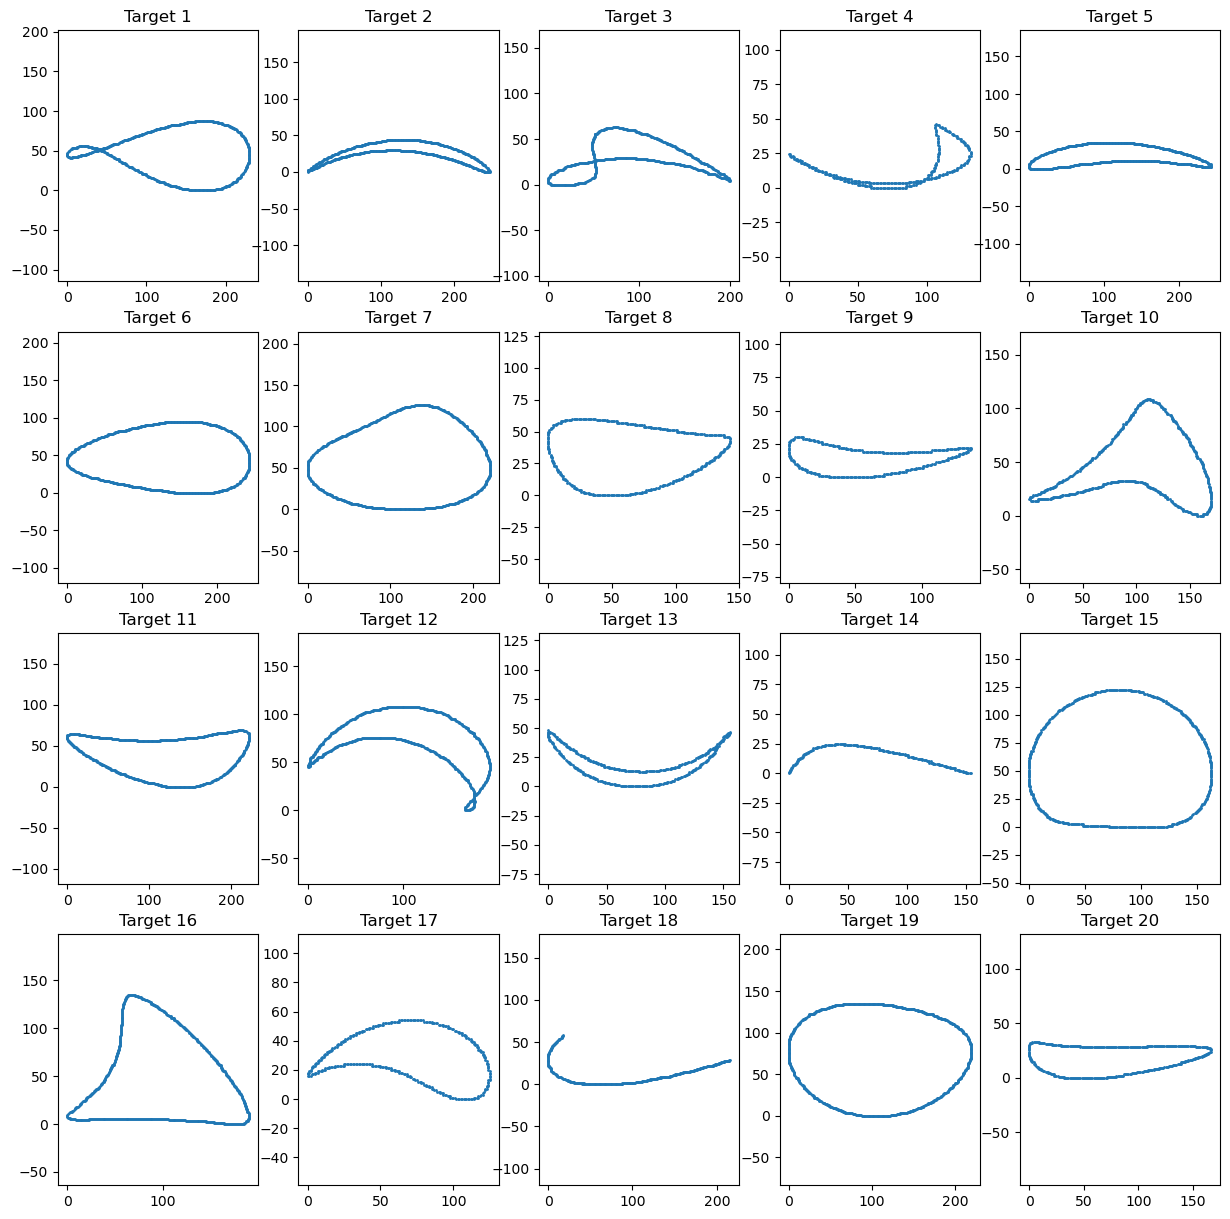

In [86]:
# Plot all target curves
fig, axs = plt.subplots(4, 5,figsize=(15,15))
for i in range(20):
    axs[i//5,i%5].scatter(np.array(target_curves[i])[:,0],np.array(target_curves[i])[:,1],s=1)
    axs[i//5,i%5].set_title('Target %i'%(i+1))
    axs[i//5,i%5].axis('equal')

### Submission Format
For your submissions we require a population of mechanisms (will be discussed later) for each target curve. For this purpose you must obtain 1D representations of each member of the population (for each target curve). To make things easier we have provided the <code>to_final_representation(C,x0,fixed_nodes,motor,target)</code> function to you in the <code>linkage_utils module</code>. We also have provided the <code>from_1D_representation(mechanism)</code> function which returns <code>C,x0,fixed_nodes,motor,target</code> from the 1D representation, essentially reversing the process. The code for this is presented in the appendix. 

You will create a .csv file with all the mechanisms each in one row of the .csv file, up to 1000, which is the limit we restrict you to. You will submit a .csv file for each target curve, therefore you will have a total of 20 .csv files. We also ask that you submit the 20 .csv files as a zip file. The naming scheme for the submission will be #.csv where you replace # with the number of the target curve starting from 0.csv and up to 19.csv.

Your performance on the targets will be measured based on the hypervolume calculated from the population. Note that there is a limit on the number of mechanisms you are permitted to submit as potential solutions for any given curve (1000). The closer you get to ideal the higher the score you will receive. The total score for your submission will be the average hypervolume for all 20 target curves:

To make this part easier we have also provided a population to .csv function which will help you make the conversion from python array to .csv for all members of a population. Since we haven't actually generated any mechanisms yet, lets generate some random ones as a placeholder. First let's use the <code>random_generator_ns</code> function we have provided to you to generate 6 random mechanisms (Note: if you pass an <code>n=#</code> parameter to this function and set # to be any number the random mechanism will have that number of nodes). We will add these 6 mechanisms to our example population. 

In [87]:
class mechanism_synthesis_optimization(ElementwiseProblem):
    
    # When intializing, set the mechanism size and target curve
    def __init__(self, target_point_cloud, N = 15):
        self.N = N
        variables = dict()
        
        for i in range(N):
            variables["C"+str(i)+"_1st"]=Integer(bounds=(0,N-1))
            variables["C"+str(i)+"_2nd"]=Integer(bounds=(0,N-1))  


        # The upper triangular portion of our NxN Connectivity Matrix consists of Nx(N-1)/2 boolean variables:
        #for i in range(N):
        #    for j in range(i):
        #        variables["C" + str(j) + "_" + str(i)] = Binary()
        
        # We Delete C0_1 since we know node 1 is connected to the motor
        #del variables["C0_1"]
        del variables["C0_1st"]
        del variables["C0_2nd"]
        del variables["C1_1st"]
        del variables["C1_2nd"]
        del variables["C2_1st"]
        del variables["C2_2nd"]
        del variables["C3_1st"]
        del variables["C3_2nd"]
     
        print(variables)
                
        #Our position matrix consists of Nx2 real numbers (cartesian coordinate values) between 0 and 1
        for i in range(2*N):
            variables["X0" + str(i)] = Real(bounds=(0.0, 1.0))

        # Our node type vector consists of N boolean variables (fixed vs non-fixed)
        
        #for i in range(2*N):
        #    variables["fixed_nodes" + str(i)] =  Binary(N)

        #del variables["fixed_nodes0"]
        #del variables["fixed_nodes3"]

        # Our target node is an integer between 1 and N-1, (any except the motor node). 
        variables["target"] = Integer(bounds=(1,N-1))
        
        # Set up some variables in the problem class we inherit for pymoo
        # n_obj=number of objectives, n_constr=number of constraints
        # Our objectives are chamfer distance and material, and they both have constraints.
        super().__init__(vars=variables, n_obj=2, n_constr=2)
        
        # Store the target curve point cloud
        self.tpc = target_point_cloud
        
        # Make a solver instance
        self.solver = mechanism_solver()
        
        # Make a normalizer instance
        self.normalizer = curve_normalizer(scale=False)
    
    def convert_1D_to_mech(self, x):
        N = self.N
        
        # Get motor, target, and driven node values
        target = x["target"]
        
        # Build connectivity matrix from its flattened constitutive variables
        C = np.zeros((N,N))
        #x["C0_1"] = 1
        x["C0_1st"] = 1 #connected to the first - not a binary value of 1
        x["C0_2nd"] = 1 #
        x["C1_1st"]=0
        x["C1_2nd"]=2
        x["C2_1st"]=1
        x["C2_2nd"]=3
        x["C3_1st"]=2
        x["C3_2nd"]=2
        
        #for i in range(N):
        #    for j in range(i):
        #        C[i,j] = x["C" + str(j) + "_" + str(i)]
        #        C[j,i] = x["C" + str(j) + "_" + str(i)]

       
        for i in range(N):
            for j in range(i):
                if(x["C"+str(i)+"_1st"]==j or x["C"+str(i)+"_2nd"]==j):
                    C[i,j]=1
                    C[j,i]=C[i,j]
        
        #add representation of C[0,1], C[1,0]
        C[0,1]=1
        C[1,0]=1

        #4 bar linkage embryo
        C[2,1]=1
        C[1,2]=1
        C[3,2]=1
        C[2,3]=1


        #print("the connectivity matrix is:", C)

        x["fixed_nodes0"]=1
        x["fixed_nodes3"]=1
        # Reshape flattened position matrix to its proper Nx2 shape 
        x0 = np.array([x["X0" + str(i)] for i in range(2*N)]).reshape([N,2])
        
        # Extract a list of Nodes that are fixed from boolean fixed_nodes vector
        #fixed_nodes = np.where(np.array([x["fixed_nodes" + str(i)] for i in range(N)]))[0].astype(np.int)
        fixed_nodes=[0, 3]
        
        #We fix the motor and original ground node as 0 and 1 respectively in this implementation
        motor=np.array([1,0])
        return target, C, x0, fixed_nodes, motor
    
    def fix_mechanism(self, target, C, x0, fixed_nodes, motor):
        #print("target: " + str(target))
        #print("fixed nodes: " + str(fixed_nodes))
        #print("motor: " + str(motor))
        
        # Make sure driven node is not grounded
        #fixed_nodes = fixed_nodes[fixed_nodes!=1]
        #print("New fixed nodes: " + str(fixed_nodes))
        # Make sure target node is not grounded
        #fixed_nodes = fixed_nodes[fixed_nodes!=target]
        fixed_nodes=[0, 3]
        motor=np.array([1,0])
        while target in fixed_nodes:
            target = np.random.choice(np.shape(C)[0])
        #print("New fixed nodes: " + str(fixed_nodes))
        #print("New motor " + str(motor))
            
        #There are many other things you can do to correct mechanisms and help your algorithm

        #remove C values that are dependent on target node
        #create a unidirected graph from the base
    
        if target>3:
          C=C[:target+1, :target+1]
          x0=x0[:target+1,:]
        else:
          C=C[:4, :4]
          x0=x0[:4,:]

        return target, C, x0, fixed_nodes, motor
    
        
    def _evaluate(self, x, out, *args, **kwargs):
        #Convert to mechanism representation
        target, C, x0, fixed_nodes, motor = self.convert_1D_to_mech(x)
        
        #Correct some potential issues in our mechanism to assist our algorithm
        target, C, x0, fixed_nodes, motor = self.fix_mechanism(target, C, x0, fixed_nodes, motor)


        #print(target, C, x0, fixed_nodes, motor)
        # Step 2: Simulate
        x_sol,locking,over_under_defined = self.solver.solve_rev(200,x0,C,motor,fixed_nodes,False)

        # check to see if the mechanism is valid
        if locking or over_under_defined:
            # if mechanism is invalid set the objective to infinity
            out["F"] = [np.Inf,np.Inf]
            out["G"] = [np.Inf,np.inf]
#             out["G"] = [locking,over_under_defined]
        else:
            # Step 3: Normalize
            x_norm = self.normalizer.get_oriented(x_sol[:,target,:])

            # Step 4: Rasterize
            out_pc = rasterized_curve_coords(x_norm,500)
            
            # Step 5: Compare
            cd = chamfer_distance(out_pc,self.tpc)

            # Send the chamfer distance to pymoo as objective
            m = self.solver.material(x0,C)
            out["F"] = [cd,m]

            # Set constraints as CD<=30 and Material<=6
            # Be careful about modifying these - designs that 
            # violate the problem constraints will not be scored.
            out["G"] = [cd - 30, m - 6]
#             out["G"] = [cd - 70, m - 6]



Now let's try this with NSGA-II and one of the easier target curves. We will initialize with mechanisms with 5 nodes. You can test what happens if you increase this number. You should quickly discover that this naive parameterization does not perform well when initializing the GA with more complex mechanisms:

Pymoo automatically saves the optimal set of solutions and their corresponding performance. <code>results.X</code> will contain the solutions in 1D representation and <code>results.F</code> will contain the objectives. Note that if none of the solutions meet the constraints, the algorithm will not save anything on the best solutions). The constraints that we specify in the problem guidelines are used as a reference point for hypervolume calculations which we will use to measure your submissions performance. 

### Now Let's Get a Submission Going

Now lets run the process for all the target curves in a loop:

{'C4_1st': <pymoo.core.variable.Integer object at 0x000001732D913970>, 'C4_2nd': <pymoo.core.variable.Integer object at 0x000001732D913880>}
Hyper Volume For Target 0 = 109.341738
{'C4_1st': <pymoo.core.variable.Integer object at 0x0000017327426100>, 'C4_2nd': <pymoo.core.variable.Integer object at 0x0000017327426610>}
Hyper Volume For Target 1 = 115.470653
{'C4_1st': <pymoo.core.variable.Integer object at 0x000001732BFD56D0>, 'C4_2nd': <pymoo.core.variable.Integer object at 0x000001732BFD5400>}
Hyper Volume For Target 2 = 89.702711
{'C4_1st': <pymoo.core.variable.Integer object at 0x000001732A1C8160>, 'C4_2nd': <pymoo.core.variable.Integer object at 0x000001732A1C8AF0>}
Hyper Volume For Target 3 = 132.803030
{'C4_1st': <pymoo.core.variable.Integer object at 0x0000017326FB8760>, 'C4_2nd': <pymoo.core.variable.Integer object at 0x0000017326FB8910>}
Hyper Volume For Target 4 = 90.447311
{'C4_1st': <pymoo.core.variable.Integer object at 0x00000173267B7880>, 'C4_2nd': <pymoo.core.variable.

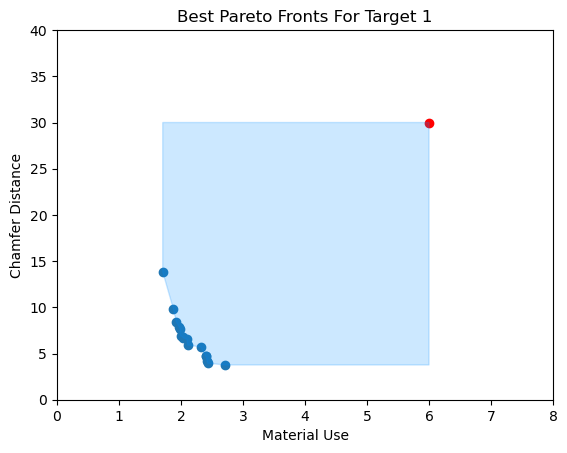

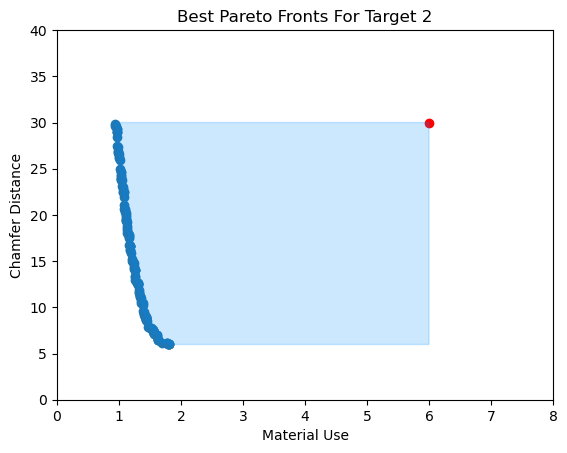

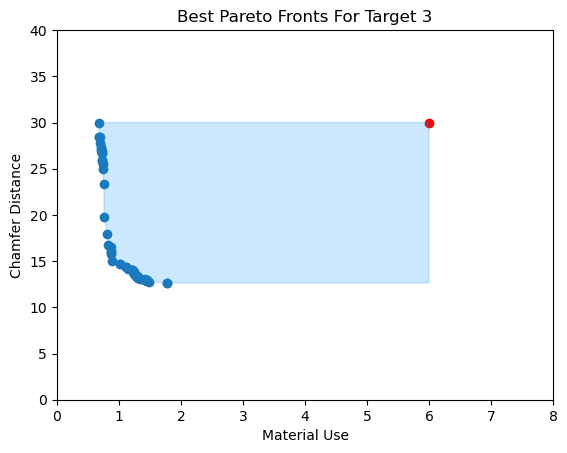

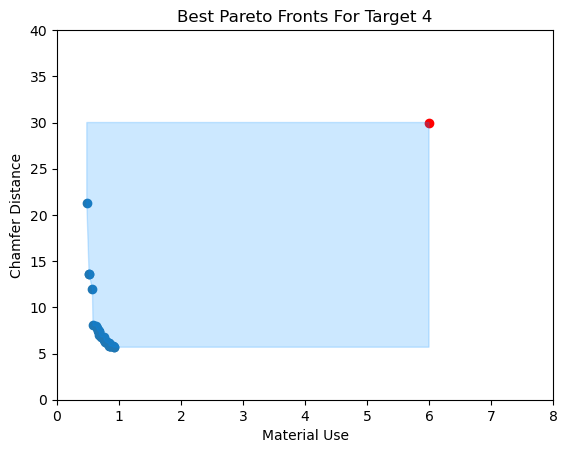

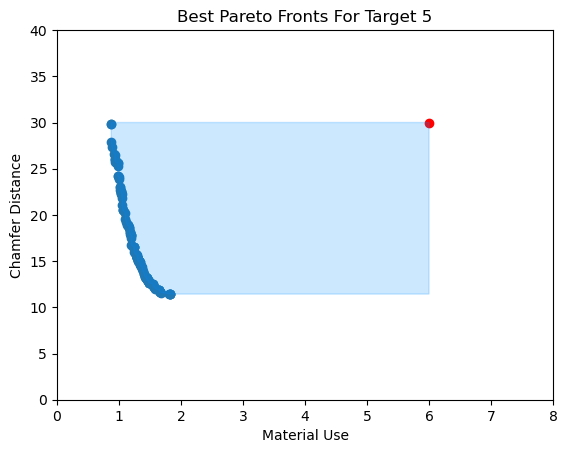

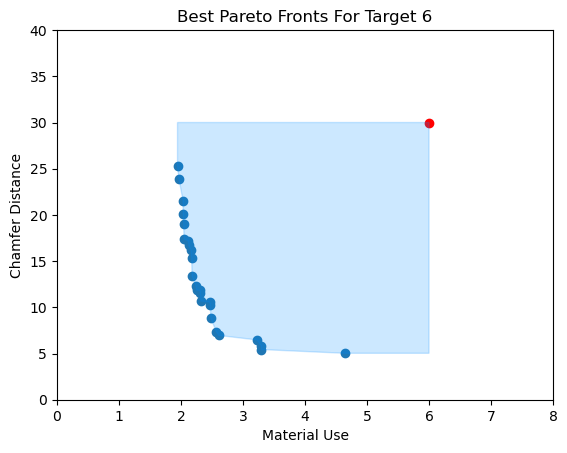

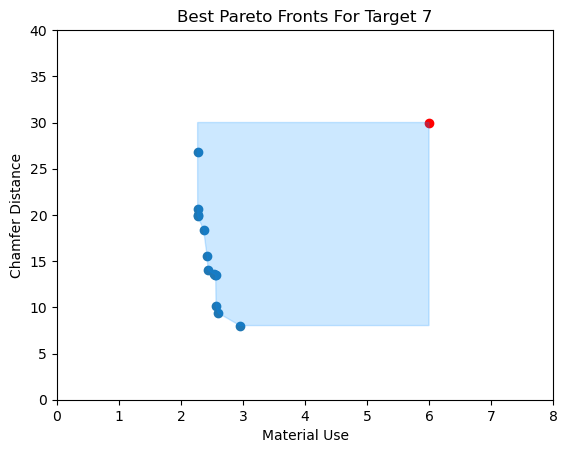

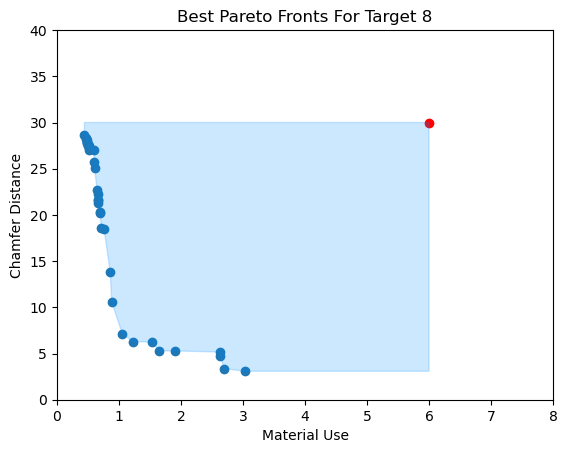

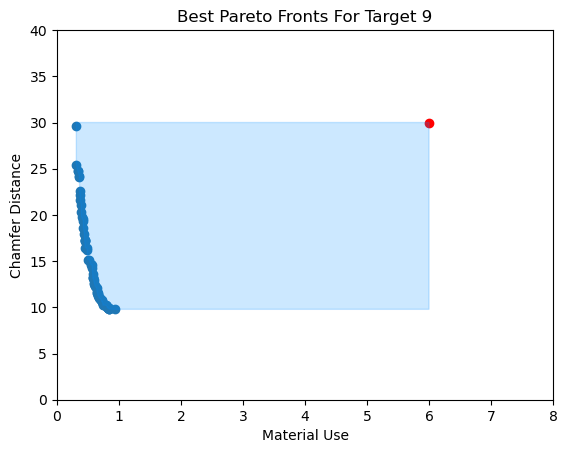

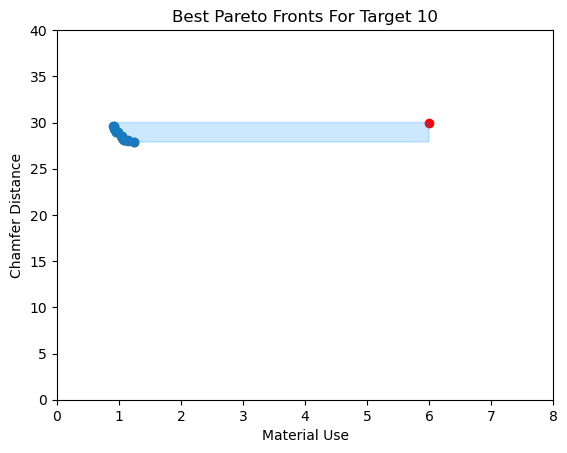

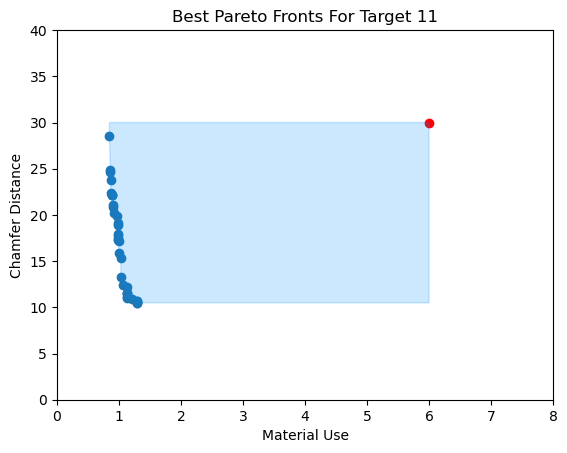

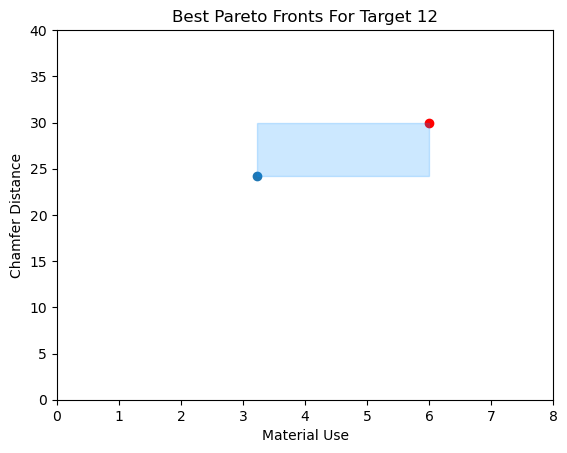

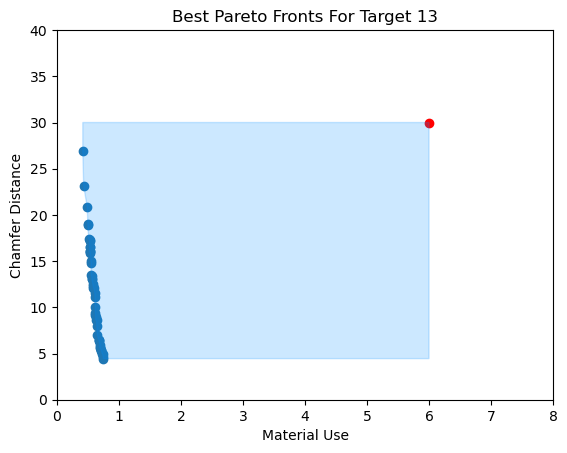

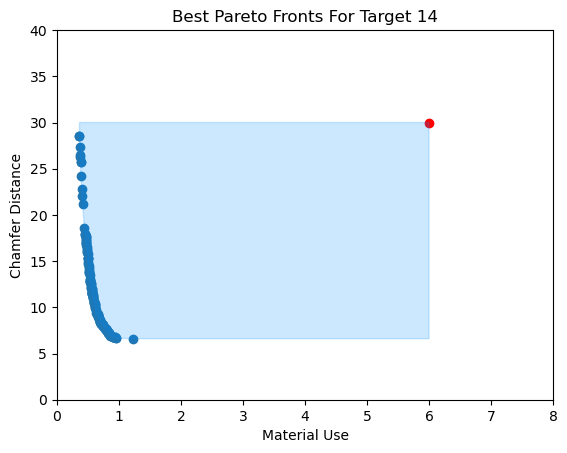

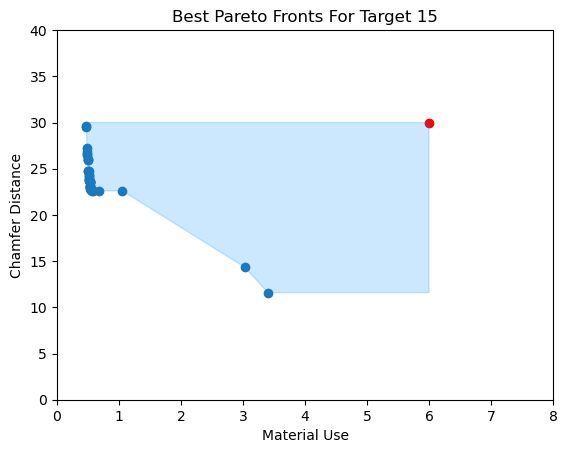

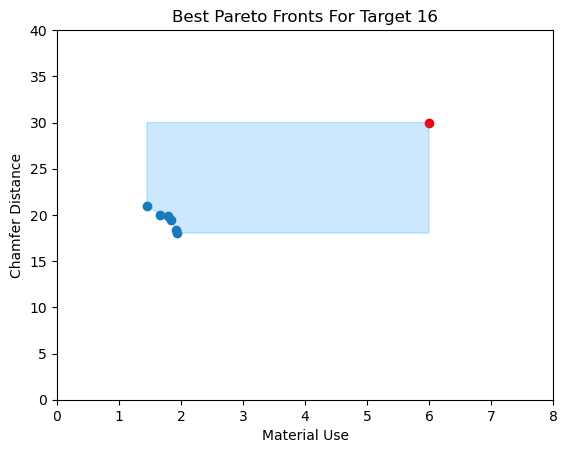

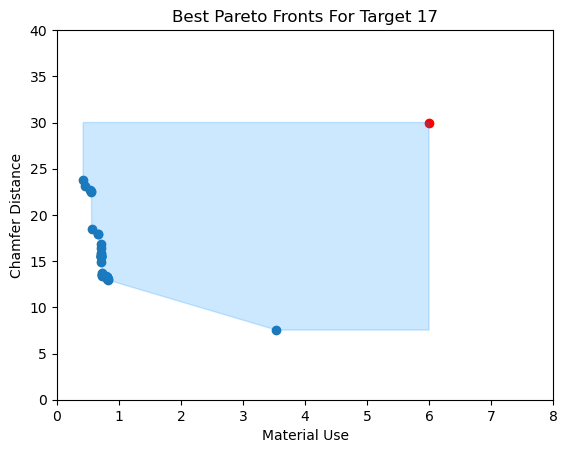

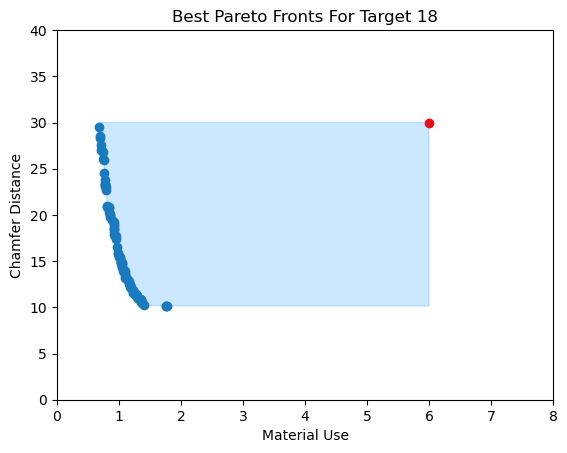

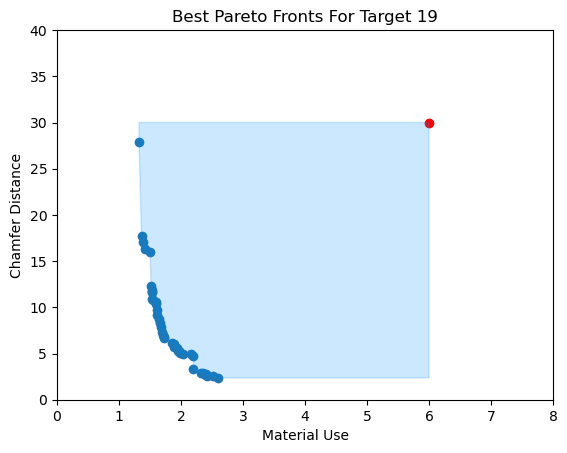

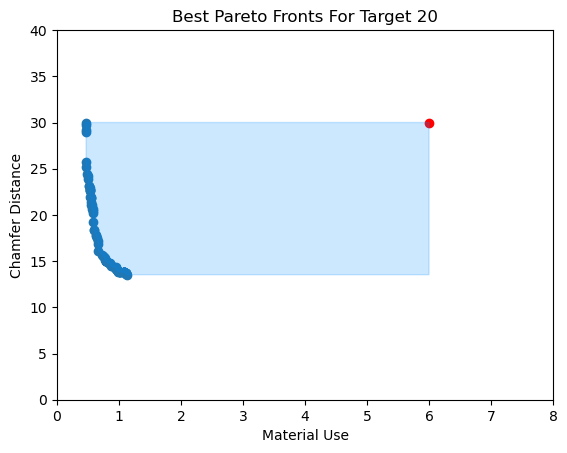

In [89]:
import time
start_time = time.time()

for i,target_curve in enumerate(target_curves):
    # Setup Problem
    problem = mechanism_synthesis_optimization(target_curve,5)

    # Get Algorithm
    algorithm = NSGA2(pop_size=150, sampling=MixedVariableSampling(),
                      mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
                      eliminate_duplicates=MixedVariableDuplicateElimination())

    # Run for 150 generations
    results = minimize(problem,
                       algorithm,
                       ('n_gen', 100),
                       verbose=True,
                       save_history=True,
                       seed=0,
                       display=best())
    
    count=0
    while results.X is None and count!=2:
        count+=1
        print('Did Not Find Solutions for Target ' + str(i) + '. Trying Seed ' + str(count+1) + '!')
        # Run for 150 generations
        results = minimize(problem,
                           algorithm,
                           ('n_gen', 150),
                           verbose=True,
                           save_history=True,
                           seed=0+count,
                           display=best())
    
    if results.X is None:
        print('Did Not Find Solutions for any Seed!!')
    else:
        mechanisms = []
        for x in results.X:
            target, C, x0, fixed_nodes, motor  = problem.convert_1D_to_mech(x)
            target, C, x0, fixed_nodes, motor  = problem.fix_mechanism(target, C, x0, fixed_nodes, motor )
            mechanisms.append(to_final_representation(C,x0,fixed_nodes,motor,target))
        
        plt.figure()
        plt.scatter(results.F[:,1],results.F[:,0])
        plt.scatter([6],[30],color="red")
        plt.xlabel('Material Use')
        plt.ylabel('Chamfer Distance')
        plt.title('Best Pareto Fronts For Target %i'%(i+1))
        plt.xlim([0,8.0])
        plt.ylim([0,40.0])
        sorted_performance = results.F[np.argsort(results.F[:,1])]
        sorted_performance = np.concatenate([sorted_performance,[[np.min(results.F[:,0]),6],[30,6],[30,np.min(results.F[:,1])]]])
        plt.fill(sorted_performance[:,1],sorted_performance[:,0],color="#008cff",alpha=0.2)

        print('Hyper Volume For Target %i = %f' % ((i),hyper_volume(results.F,[30.0,6.0])))
        
        save_population_csv('./results/FixMech/%i.csv'%i,mechanisms)
print("--- Execution time: %s seconds ---" % (time.time() - start_time))

Now Let's see how we did:

In [ ]:
evaluate_submission()

100%|██████████| 20/20 [00:04<00:00,  4.20it/s]

Score Break Down:
Curve 0: 93.775652
Curve 1: 123.607384
Curve 2: 78.459725
Curve 3: 129.360815
Curve 4: 105.328502
Curve 5: 82.327254
Curve 6: 109.684139
Curve 7: 135.075503
Curve 8: 142.130149
Curve 9: 103.111768
Curve 10: 110.153627
Curve 11: 68.104333
Curve 12: 128.187838
Curve 13: 118.244167
Curve 14: 135.631685
Curve 15: 56.214797
Curve 16: 108.475660
Curve 17: 103.610635
Curve 18: 123.579131
Curve 19: 93.595545
Overall Score: 107.432915


107.43291528323248

### Extra Material and Challenges With the Current Implemenation

#### Some Important Notes:

<ul>
    <li><b>Random Seeds: </b>If you plan to run things in the notebook please do not forget to remove the random seeds from the code we set the seeds so that the results of the code do not change when you run them again, and you would obviously have better results if you randomize differently every time.</li>
    <li><b>Colab vs Local: </b>If you do plan to use Google Colab for your work remember to download any files you save and the changes to the notebook because every time Google Colab ends the runtime (or it times out) it deletes all files and progress. So <font color="red"><b>BE CAREFUL!</b></font></li> It is generally recommended that you work locally.
</ul>

#### Problems With The Current Implementation:

The current implementation has a few problems (your task is to improve upon this). The first is that the method cannot handle very large sizes of mechanisms and it struggles to find mechanisms that are not locking or under/over defined. Lets see the algorithm try to make mechanisms of size 12. To give it a chance lets run it for 1000 generations:

In [ ]:
# Setup Problem
problem = mechanism_synthesis_optimization(target_curve,12)

# Get Algorithm
algorithm = NSGA2(pop_size=50, sampling=MixedVariableSampling(),
                      mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
                      eliminate_duplicates=MixedVariableDuplicateElimination())

# Run for 1000 generations
results = minimize(problem,
                   algorithm,
                   ('n_gen', 1000),
                   verbose=True,
                   save_history=True,
                   seed=0)

{'C4_1st': <pymoo.core.variable.Integer object at 0x000001731AD09310>, 'C4_2nd': <pymoo.core.variable.Integer object at 0x000001731AD096A0>, 'C5_1st': <pymoo.core.variable.Integer object at 0x000001731AD09AC0>, 'C5_2nd': <pymoo.core.variable.Integer object at 0x000001731AD09370>, 'C6_1st': <pymoo.core.variable.Integer object at 0x000001731AD09E80>, 'C6_2nd': <pymoo.core.variable.Integer object at 0x0000017323B1D850>, 'C7_1st': <pymoo.core.variable.Integer object at 0x0000017323B1DAF0>, 'C7_2nd': <pymoo.core.variable.Integer object at 0x0000017323B1DBB0>, 'C8_1st': <pymoo.core.variable.Integer object at 0x0000017323B1D4C0>, 'C8_2nd': <pymoo.core.variable.Integer object at 0x0000017323B1DB20>, 'C9_1st': <pymoo.core.variable.Integer object at 0x0000017323B1D970>, 'C9_2nd': <pymoo.core.variable.Integer object at 0x0000017323B1D880>, 'C10_1st': <pymoo.core.variable.Integer object at 0x0000017323B1DE50>, 'C10_2nd': <pymoo.core.variable.Integer object at 0x0000017323B1D9D0>, 'C11_1st': <pymoo

As you can see it can't get out of the infeasable region. What can we do to fix this problem for larger mechanisms??

Since we know that our mechanism has one degree of freedom, does the current way we have represented our mechanism really the most efficient way to do this? Does the current Mutation/Crossover/Initialization make sense?  Is Genetic Algorthim really the best way to do this? What are the ways you can improve this method?

Understanding evolutionary design of linkages is key to developing better methods for this process. Look at :


<font size="3"><b>Lipson, H. (2008). Evolutionary synthesis of kinematic mechanisms. Artificial Intelligence for Engineering Design, Analysis and Manufacturing, 22(3), 195-205. </b></font> [Online PDF](https://www.cambridge.org/core/journals/ai-edam/article/evolutionary-synthesis-of-kinematic-mechanisms/6DF594784096ECD1C66E9F8CB9AAB0AE)

<font size="3"><b>Bacher, M., Coros, S., Thomaszewski, B. (2015). LinkEdit: interactive linkage editing using symbolic kinematics. ACM Transactions on Graphics (TOG), 34(4), 99.</b></font> [Online (Access Through MIT)](https://libproxy.mit.edu/login?url=https://dl.acm.org/doi/10.1145/2766985)

Other references:

<font size="2">Deshpande, Shrinath, en Anurag Purwar. A Machine Learning Approach to Kinematic Synthesis of Defect-Free Planar Four-Bar Linkages. Vol 5B: 42nd Mechanisms and Robotics Conference. International Design Engineering Technical Conferences and Computers and Information in Engineering Conference, 08 2018.</font> [Online (Access Through MIT)](https://libproxy.mit.edu/login?url=https://doi.org/10.1115/DETC2018-85578)


<font size="2">Vermeer, Kaz, Reinier Kuppens, en Justus Herder. Kinematic Synthesis Using Reinforcement Learning. Vol 2A: 44th Design Automation Conference. International Design Engineering Technical Conferences and Computers and Information in Engineering Conference, 08 2018.</font> [Online (Access Through MIT)](https://libproxy.mit.edu/login?url=https://doi.org/10.1115/DETC2018-85529)